# Load libraries and data

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['R_HOME'] = "/usr/lib/R/"
import scanpy as sc
import scFates as scf
import numpy as np
import pandas as pd
import anndata
sc.set_figure_params(figsize=(5,5),dpi_save=600)
emb_back=pd.read_csv("_Output/tsne_pal-6.csv",index_col=0).values

In [2]:
adata=sc.read("_Output/adata_early.h5ad")
cells_pou4f1=adata[adata.obs.seg=="2"].obs_names
cells_rest=adata[adata.obs.seg=="1"].obs_names

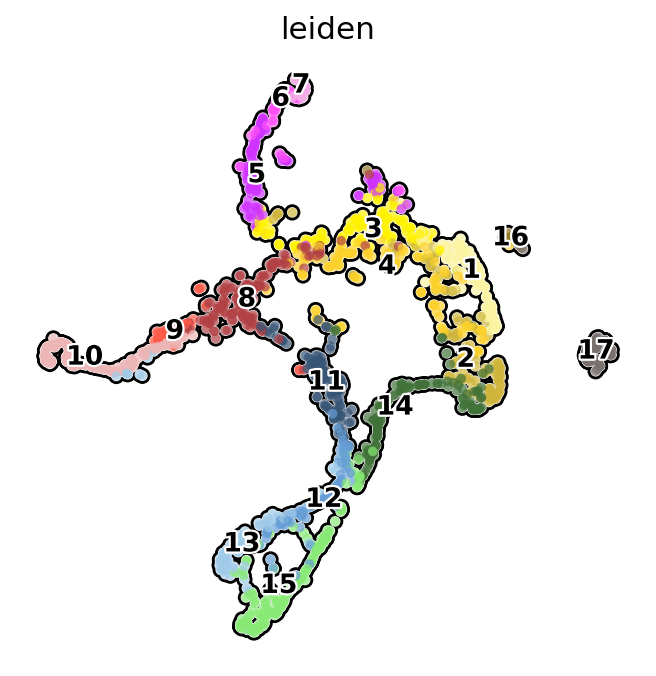

In [3]:
adata=sc.read("_Output/adata_SGN.h5ad")
adata_all=adata.copy()
sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

In [4]:
selection=cells_rest.tolist()+adata.obs_names[adata.obs.leiden.isin(list(range(5,14)))].tolist()

In [5]:
adata=adata[selection,]

# Principal tree inference

In [6]:
scf.tl.tree(adata,use_rep="diffusion",Nodes=300,method="ppt",ppt_lambda=1,ppt_sigma=.25,seed=1)


inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.25, lambda = 1
    : 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]

Trying to set attribute `.uns` of view, copying.



    not converged (error: 0.006196727316935891)
    finished (0:00:09) --> added 
    'ppt', dictionnary containing inferred tree (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment of cells to principal point in representation space (adata.uns)
    'tree/F', coordinates of principal points in representation space (adata.uns)


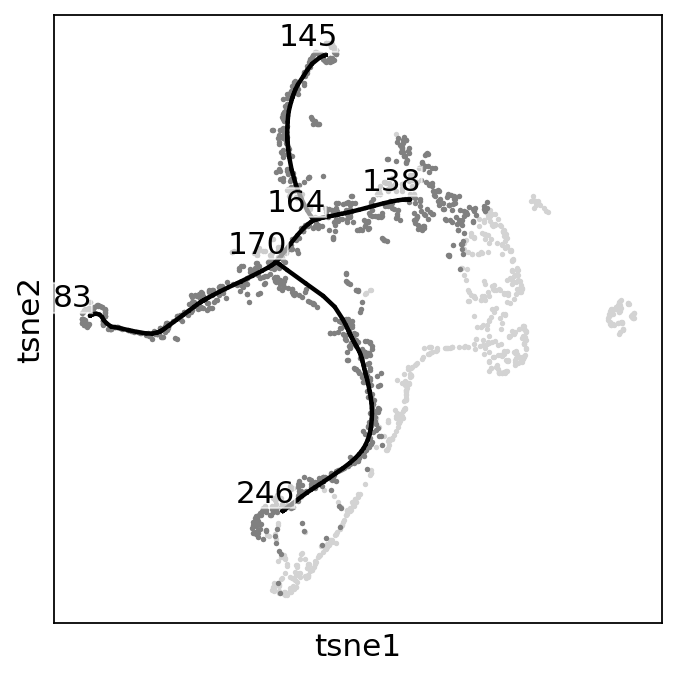

In [7]:
scf.pl.tree(adata,basis="tsne",emb_back=emb_back,size_nodes=.1)

In [8]:
scf.tl.root(adata,138)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)


In [9]:
scf.tl.pseudotime(adata)

projecting cells onto the principal tree
    finished (0:00:01) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)


In [10]:
dct_col=dict(zip(["bifurcation1","Ia","II","Ib","early_pool","bifurcation2"],
                 ["navajowhite","orangered","violet","royalblue","lightyellow","goldenrod"]))

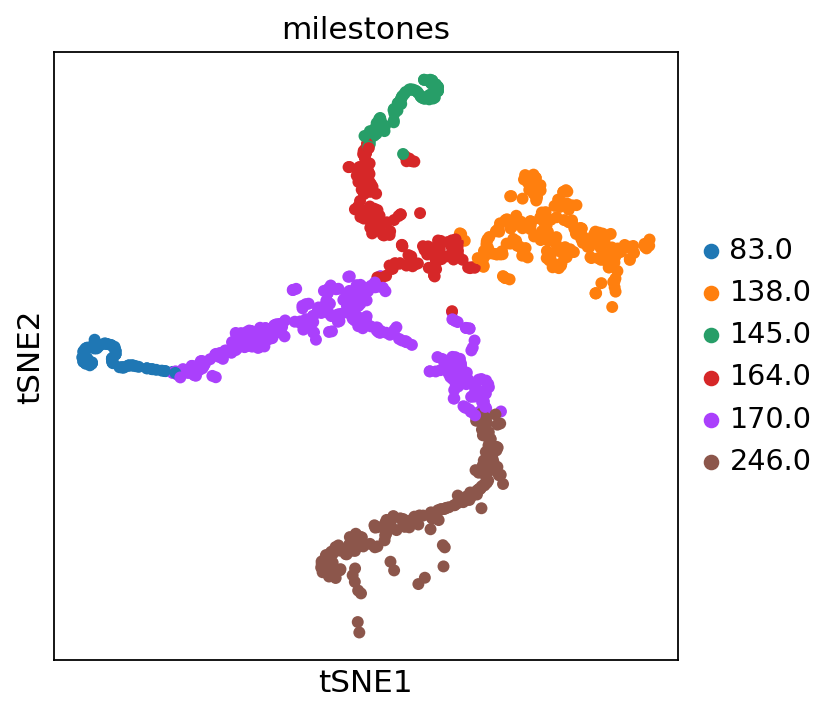

In [11]:
sc.set_figure_params(figsize=(5,5),dpi_save=600)
sc.pl.tsne(adata,color="milestones")

In [12]:
mil=["Ia","early_pool","II","bifurcation1","bifurcation2","Ib"]
adata.obs.milestones=adata.obs.milestones.cat.rename_categories(mil)

In [13]:
import matplotlib.pyplot as plt
sc.set_figure_params(figsize=(5,5),dpi_save=600)
fig,ax=plt.subplots()
sc.pl.tsne(adata_all,ax=ax,show=False)
sc.pl.tsne(adata,color="milestones",palette=pd.Series(dct_col).loc[mil].values.tolist(),ax=ax,add_outline=True,show=False,save="-bifurcation.png")

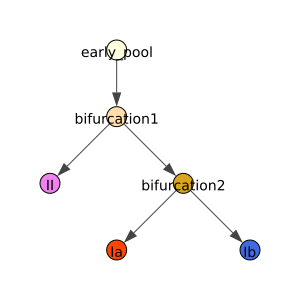

In [14]:
scf.pl.milestones(adata,figsize=(300,300))

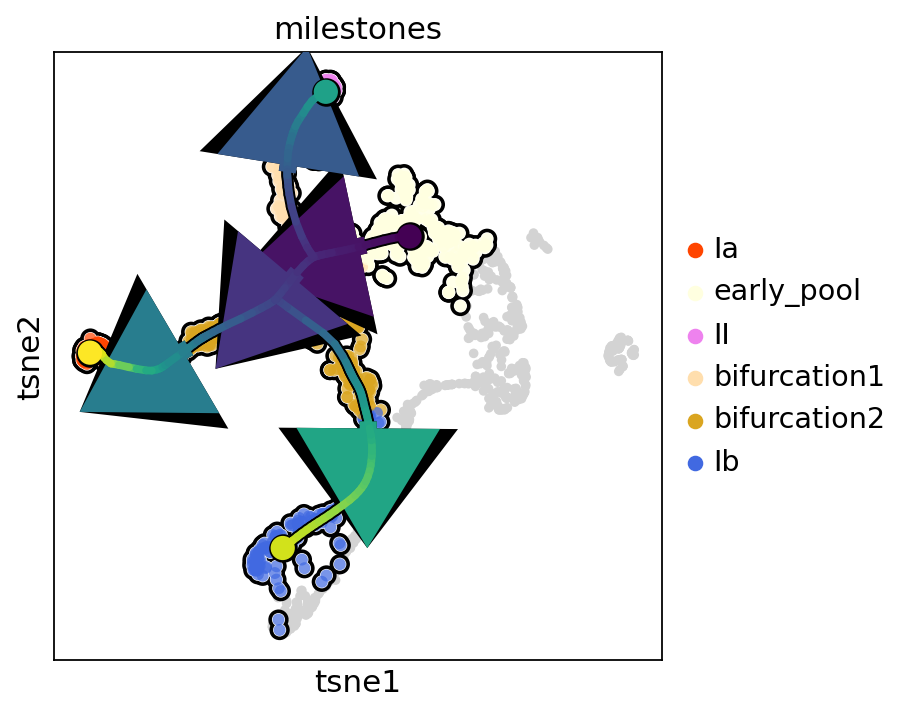

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sc.pl.scatter(adata_all,basis="tsne",color="lightgrey",ax=ax,show=False)
sc.pl.tsne(adata,color="milestones",palette=pd.Series(dct_col).loc[mil].values.tolist(),add_outline=True,ax=ax,show=False)
sc.set_figure_params(figsize=(5,5),dpi_save=600)
scf.pl.trajectory(adata,basis="tsne",arrows=True,scale_path=.7,save="bifurcation_trajectory.png",alpha_cells=0,ax=ax)

In [16]:
adata_Ic=sc.read("_Output/adata_Ic_tree.h5ad")

In [17]:
adata_Ic.obs.milestones=adata_Ic.obs.milestones.cat.rename_categories(['early_Ic','Ic'])

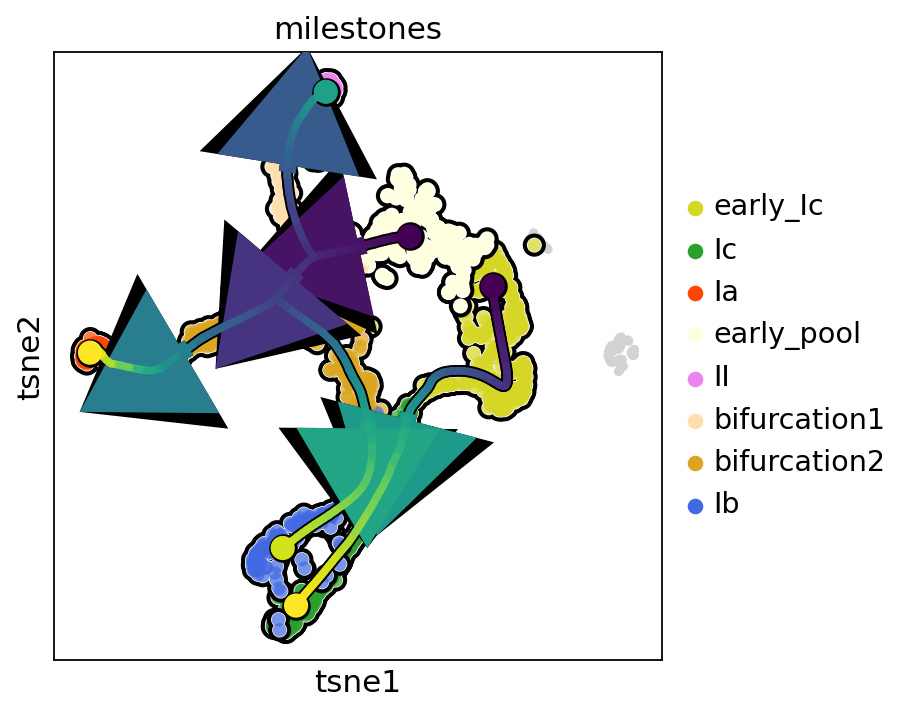

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sc.pl.scatter(adata_all,basis="tsne",color="lightgrey",ax=ax,show=False)
sc.pl.tsne(adata_Ic,color="milestones",palette=["#D6D626","#2CA02C"],add_outline=True,ax=ax,show=False,size=150)
scf.pl.trajectory(adata_Ic,basis="tsne",arrows=True,scale_path=.7,alpha_cells=0,ax=ax,show=False)
sc.pl.tsne(adata,color="milestones",palette=pd.Series(dct_col).loc[mil].values.tolist(),add_outline=True,ax=ax,show=False,size=150)
sc.set_figure_params(figsize=(5,5),dpi_save=600)
scf.pl.trajectory(adata,basis="tsne",arrows=True,scale_path=.7,save="bifurcation_trajectory_All.png",alpha_cells=0,ax=ax)

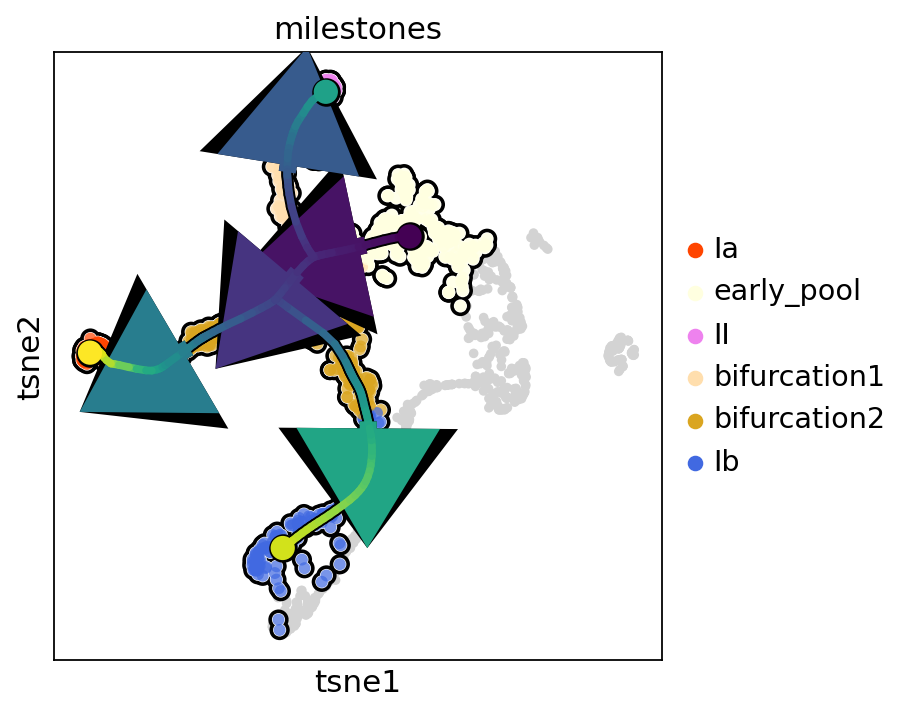

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sc.pl.scatter(adata_all,basis="tsne",color="lightgrey",ax=ax,show=False)
sc.pl.tsne(adata,color="milestones",palette=pd.Series(dct_col).loc[mil].values.tolist(),add_outline=True,ax=ax,show=False)
sc.set_figure_params(figsize=(5,5),dpi_save=600)
scf.pl.trajectory(adata,basis="tsne",arrows=True,scale_path=.7,save="bifurcation_trajectory.png",alpha_cells=0,ax=ax)

# Test and fit associated regulons

In [20]:
scf.tl.test_association(adata,layer="fpm",n_jobs=20)

test features for association with the tree
    mapping 0: 100%|██████████| 27210/27210 [03:26<00:00, 131.82it/s]
    found 1493 significant features (0:03:27) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/stat_assoc_list', list of fitted features on the tree for all mappings (adata.uns)


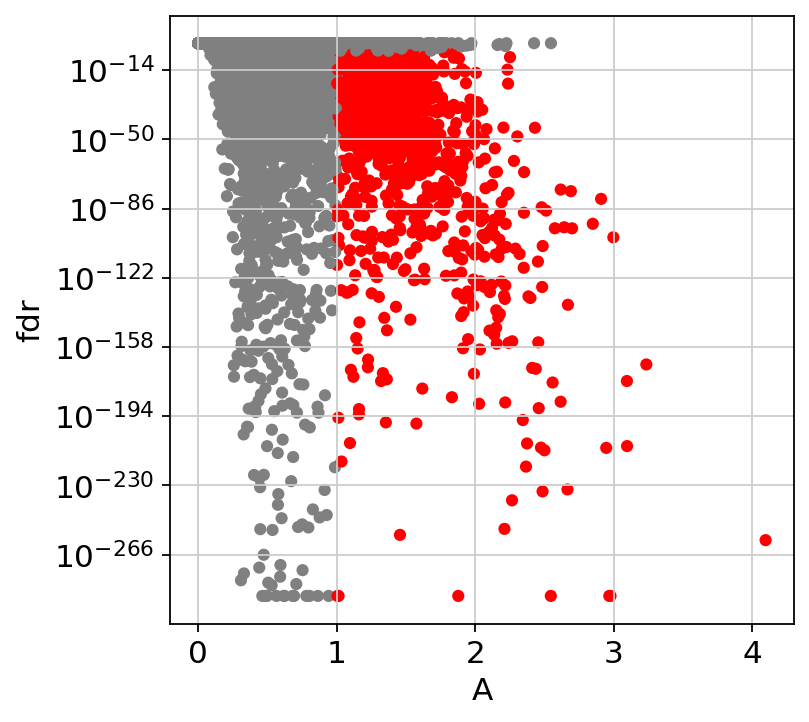

In [21]:
scf.pl.test_association(adata)

In [22]:
scf.tl.fit(adata,layer="fpm",n_jobs=20)

fit features associated with the tree
    mapping 0: 100%|██████████| 1493/1493 [00:43<00:00, 34.49it/s] 
    finished (adata subsetted to keep only fitted features!) (0:00:45) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


# Bifurcation analysis

## Ia vs Ib

In [23]:
scf.tl.test_fork(adata,layer="fpm",root_milestone="early_pool",milestones=["Ia","Ib"],n_jobs=20)

testing fork
    mapping: 0
    differential expression: 100%|██████████| 1493/1493 [00:04<00:00, 309.11it/s]
    test for upregulation for each leave vs root
    leave Ib: 100%|██████████| 1493/1493 [00:01<00:00, 1000.58it/s]
    finished (0:00:11) --> added 
    'early_pool->Ia<>Ib/fork', DataFrame with fork test results (adata.uns)


In [24]:
scf.tl.branch_specific(adata,root_milestone="early_pool",milestones=["Ia","Ib"],effect_b1=0.2,effect_b2=0.4)

    72 features found to be specific to leave Ia
    76 features found to be specific to leave Ib
    finished --> updated 
    'early_pool->Ia<>Ib/fork', DataFrame updated with additionnal 'branch' column (adata.uns)


In [25]:
scf.tl.activation(adata,layer="fpm",root_milestone="early_pool",milestones=["Ia","Ib"],n_jobs=20,deriv_cut=0.02)

testing activation
    leave Ib: 100%|██████████| 76/76 [00:00<00:00, 1115.64it/s]
    24 early and 48 late features specific to leave Ia
    18 early and 58 late features specific to leave Ib
    finished (0:00:02) --> updated 
    'early_pool->Ia<>Ib/fork', DataFrame updated with additionnal 'activation' and 'module' columns (adata.uns)


In [26]:
adata.uns['early_pool->Ia<>Ib']['fork'].to_csv("supp_Fig3e.csv")

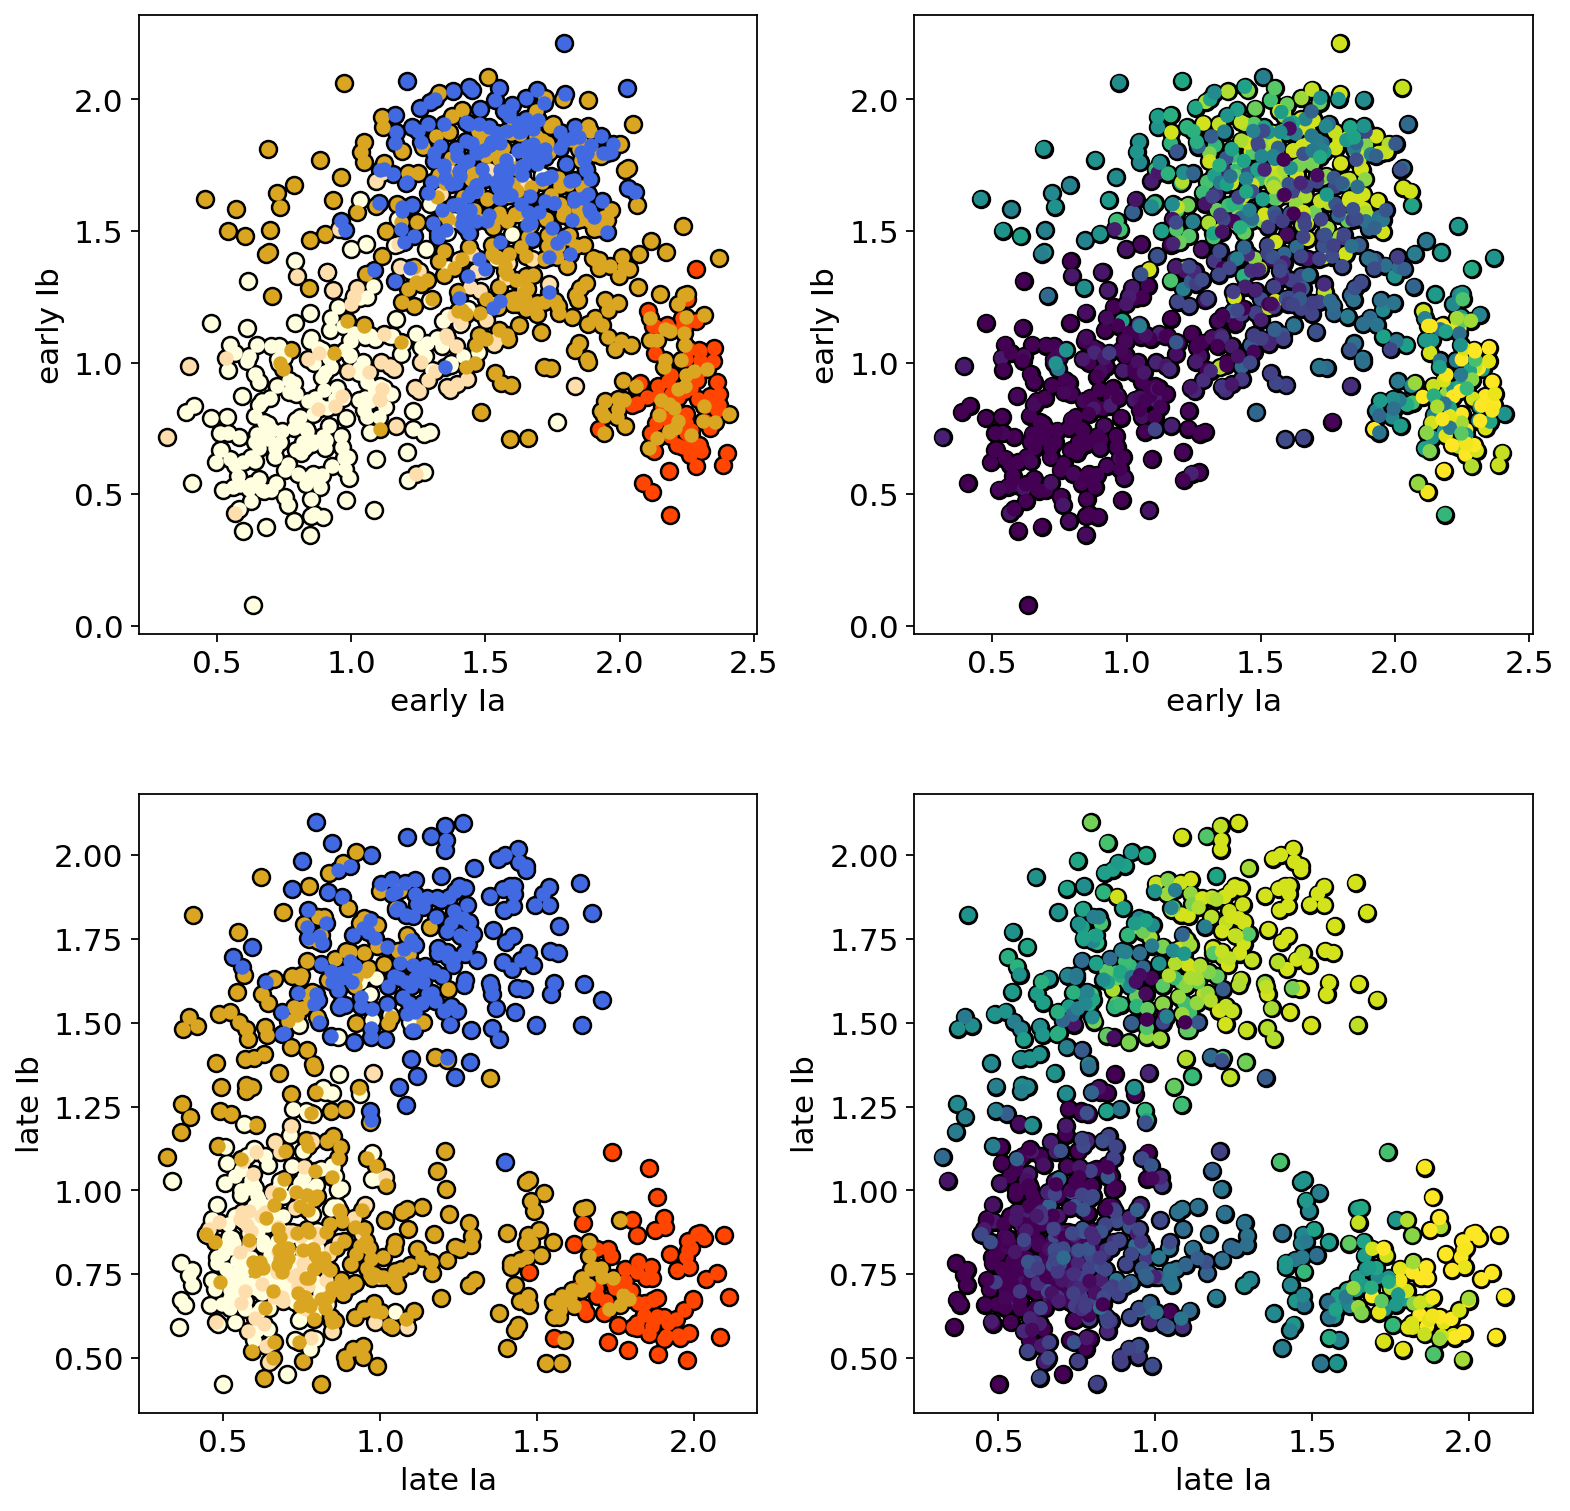

In [27]:
sc.set_figure_params(figsize=(8,8),dpi_save=600)
scf.pl.modules(adata,layer="fpm",root_milestone="early_pool",milestones=["Ia","Ib"],
               highlight=True,marker_size=30,save="-Ib_vs_Ia.png")

In [28]:
scf.tl.slide_cells(adata,root_milestone="early_pool",milestones=["Ia","Ib"],win=80)

--> added 
    'early_pool->Ia<>Ib/cell_freq', probability assignment of cells on 12 non intersecting windows (adata.uns)


In [29]:
scf.tl.slide_cors(adata,layer="fpm",root_milestone="early_pool",milestones=["Ia","Ib"])

--> added 
    'early_pool->Ia<>Ib/corAB', gene-gene correlation modules (adata.uns)


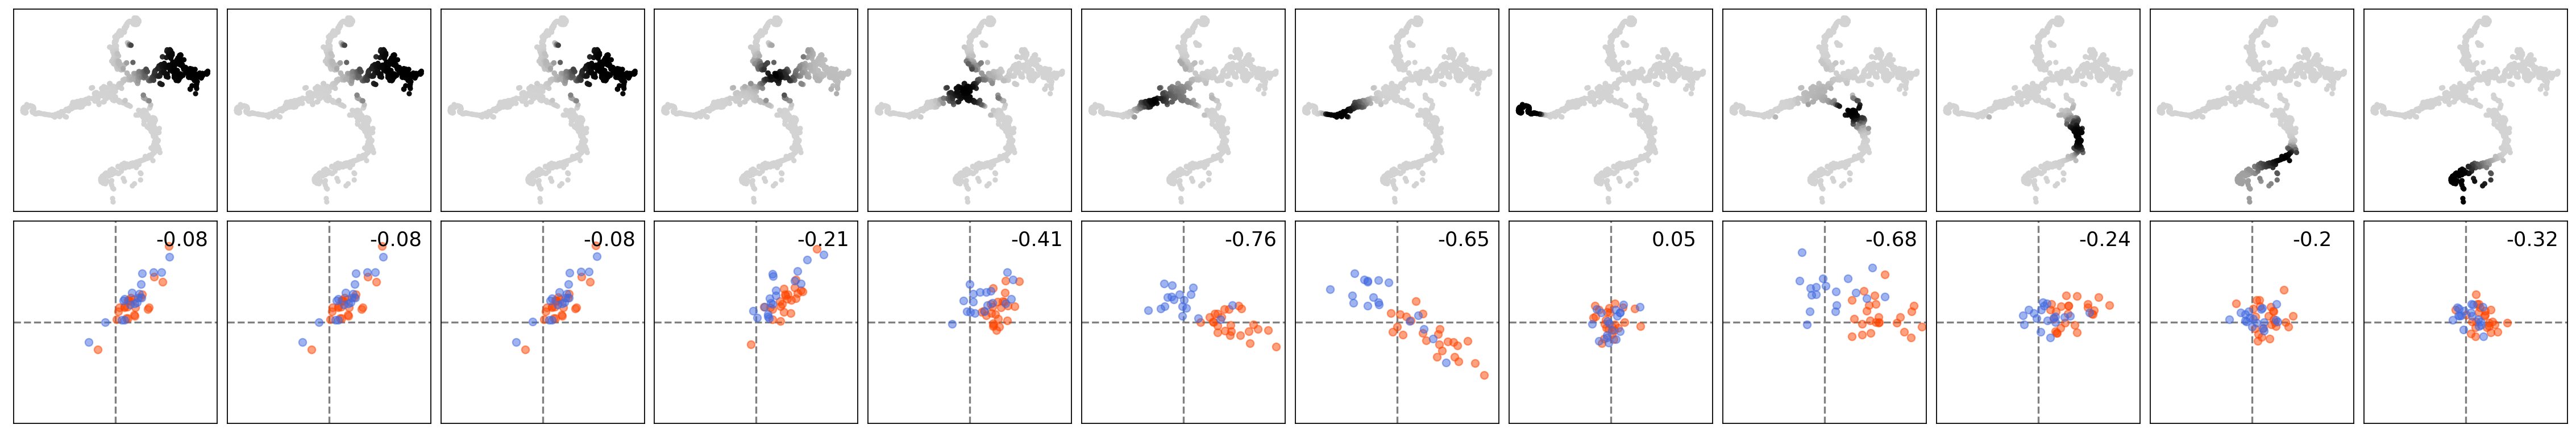

In [30]:
scf.pl.slide_cors(adata,basis="tsne",root_milestone="early_pool",milestones=["Ia","Ib"],save="-Ib_vs_Ia.png")

In [31]:
adata.uns["early_pool->Ia<>Ib"]["corAB"].to_csv("supp_Fig3g.csv")

## II vs Ia

In [32]:
scf.tl.test_fork(adata,layer="fpm",root_milestone="early_pool",milestones=["II","Ia"],n_jobs=20)

testing fork
    mapping: 0
    differential expression: 100%|██████████| 1493/1493 [00:07<00:00, 210.74it/s]
    test for upregulation for each leave vs root
    leave Ia: 100%|██████████| 1493/1493 [00:02<00:00, 544.55it/s]
    finished (0:00:12) --> added 
    'early_pool->II<>Ia/fork', DataFrame with fork test results (adata.uns)


In [33]:
scf.tl.branch_specific(adata,root_milestone="early_pool",milestones=["II","Ia"],effect_b1=0.3,effect_b2=0.6)

    78 features found to be specific to leave II
    63 features found to be specific to leave Ia
    finished --> updated 
    'early_pool->II<>Ia/fork', DataFrame updated with additionnal 'branch' column (adata.uns)


In [34]:
scf.tl.activation(adata,layer="fpm",root_milestone="early_pool",milestones=["II","Ia"],n_jobs=20)

testing activation
    leave Ia: 100%|██████████| 63/63 [00:00<00:00, 1041.60it/s]
    18 early and 60 late features specific to leave II
    12 early and 51 late features specific to leave Ia
    finished (0:00:02) --> updated 
    'early_pool->II<>Ia/fork', DataFrame updated with additionnal 'activation' and 'module' columns (adata.uns)


In [35]:
adata.uns['early_pool->II<>Ia']['fork'].to_csv("supp_Fig3d.csv")

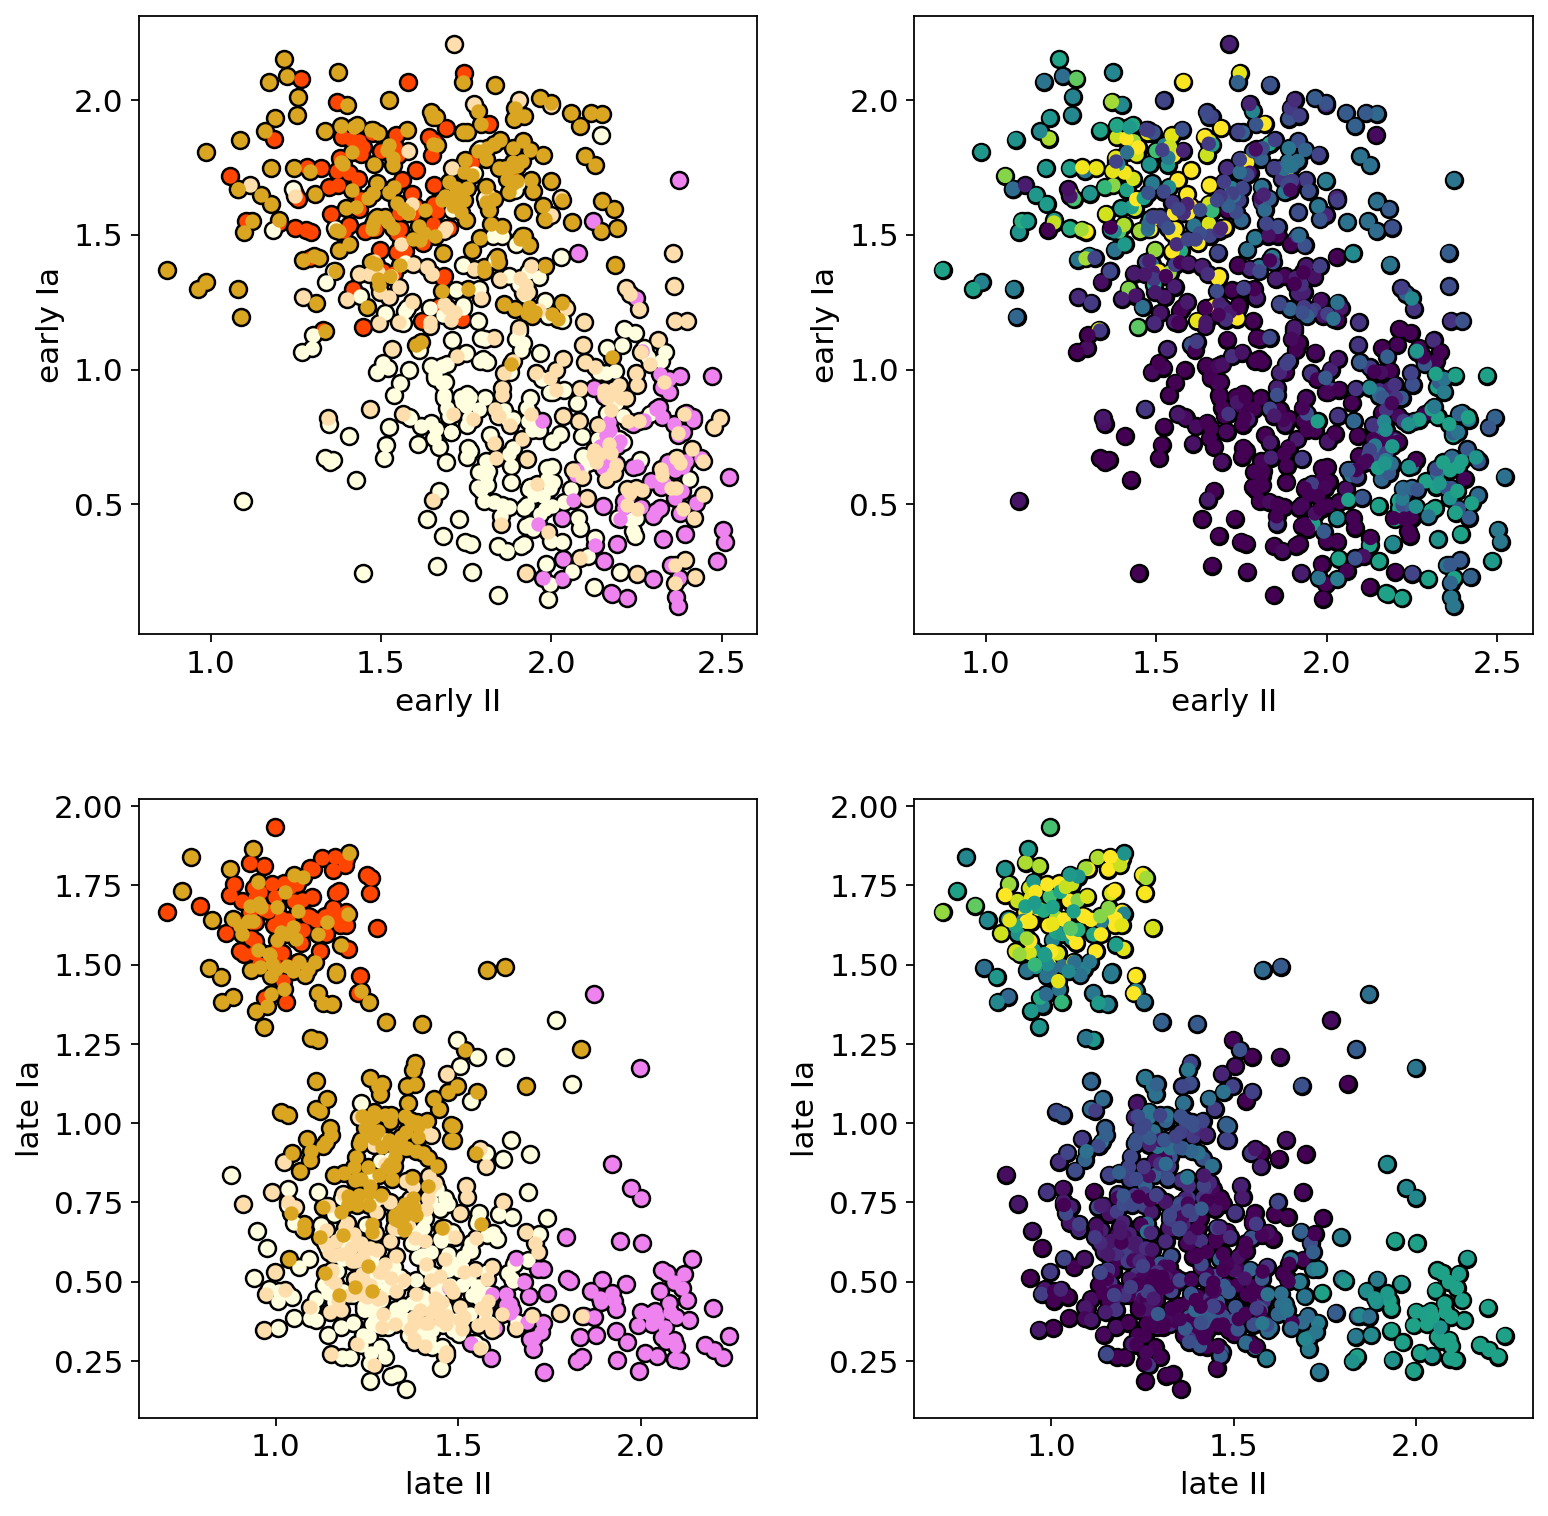

In [36]:
sc.set_figure_params(figsize=(8,8),dpi_save=600)
scf.pl.modules(adata[adata.obs.t.sort_values(ascending=False).index,],layer="fpm",root_milestone="early_pool",milestones=["II","Ia"],
               highlight=True,marker_size=30,save="-II_vs_Ia.png")

In [37]:
scf.tl.slide_cells(adata,root_milestone="early_pool",milestones=["II","Ia"],win=70)

--> added 
    'early_pool->II<>Ia/cell_freq', probability assignment of cells on 11 non intersecting windows (adata.uns)


In [38]:
scf.tl.slide_cors(adata,layer="fpm",root_milestone="early_pool",milestones=["II","Ia"])

--> added 
    'early_pool->II<>Ia/corAB', gene-gene correlation modules (adata.uns)


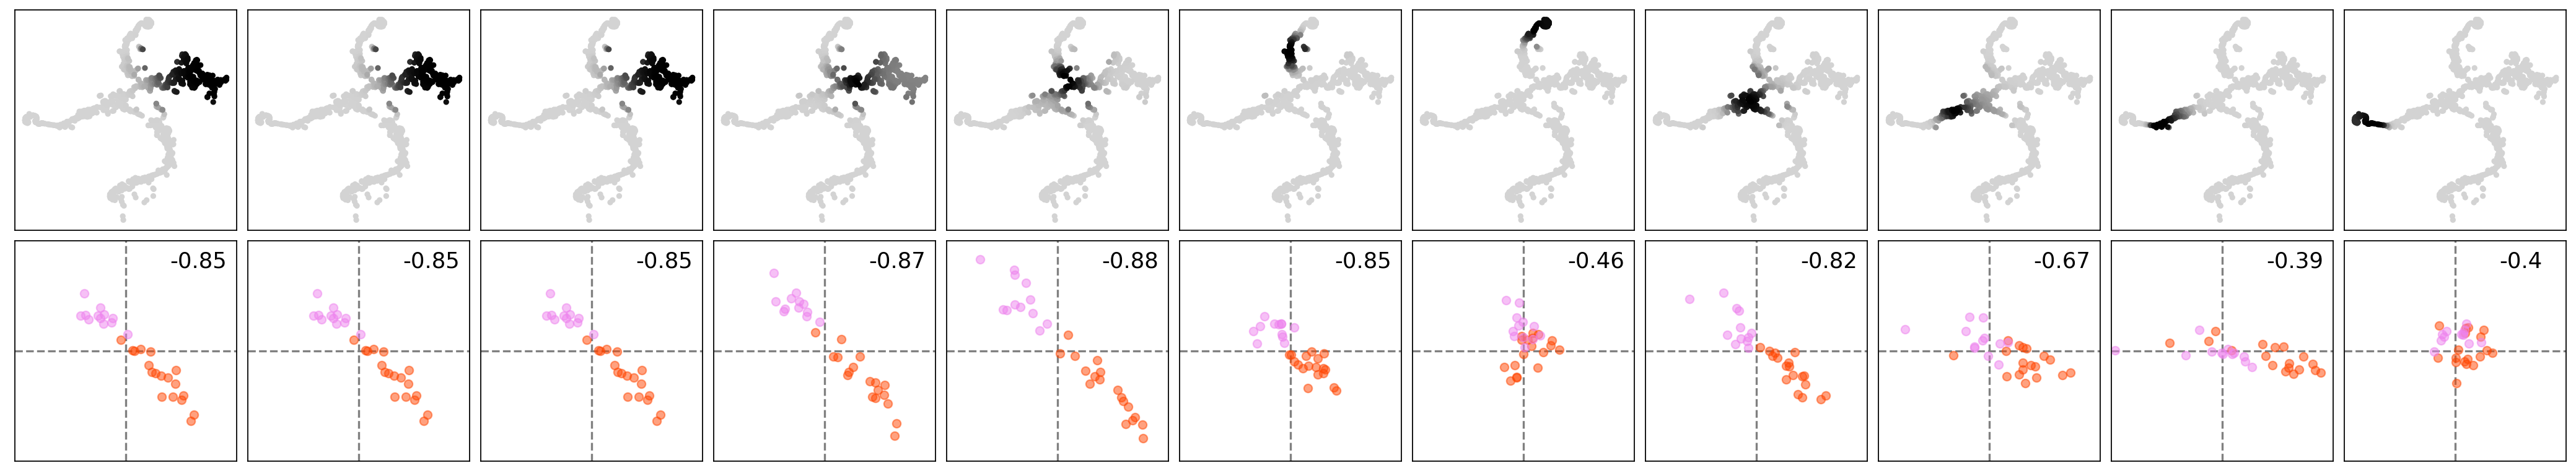

In [39]:
scf.pl.slide_cors(adata,basis="tsne",root_milestone="early_pool",milestones=["II","Ia"],save="-II_vs_Ia.png")

In [40]:
adata.uns["early_pool->II<>Ia"]["corAB"].to_csv("supp_Fig3f.csv")

### pre-bifurcation focus

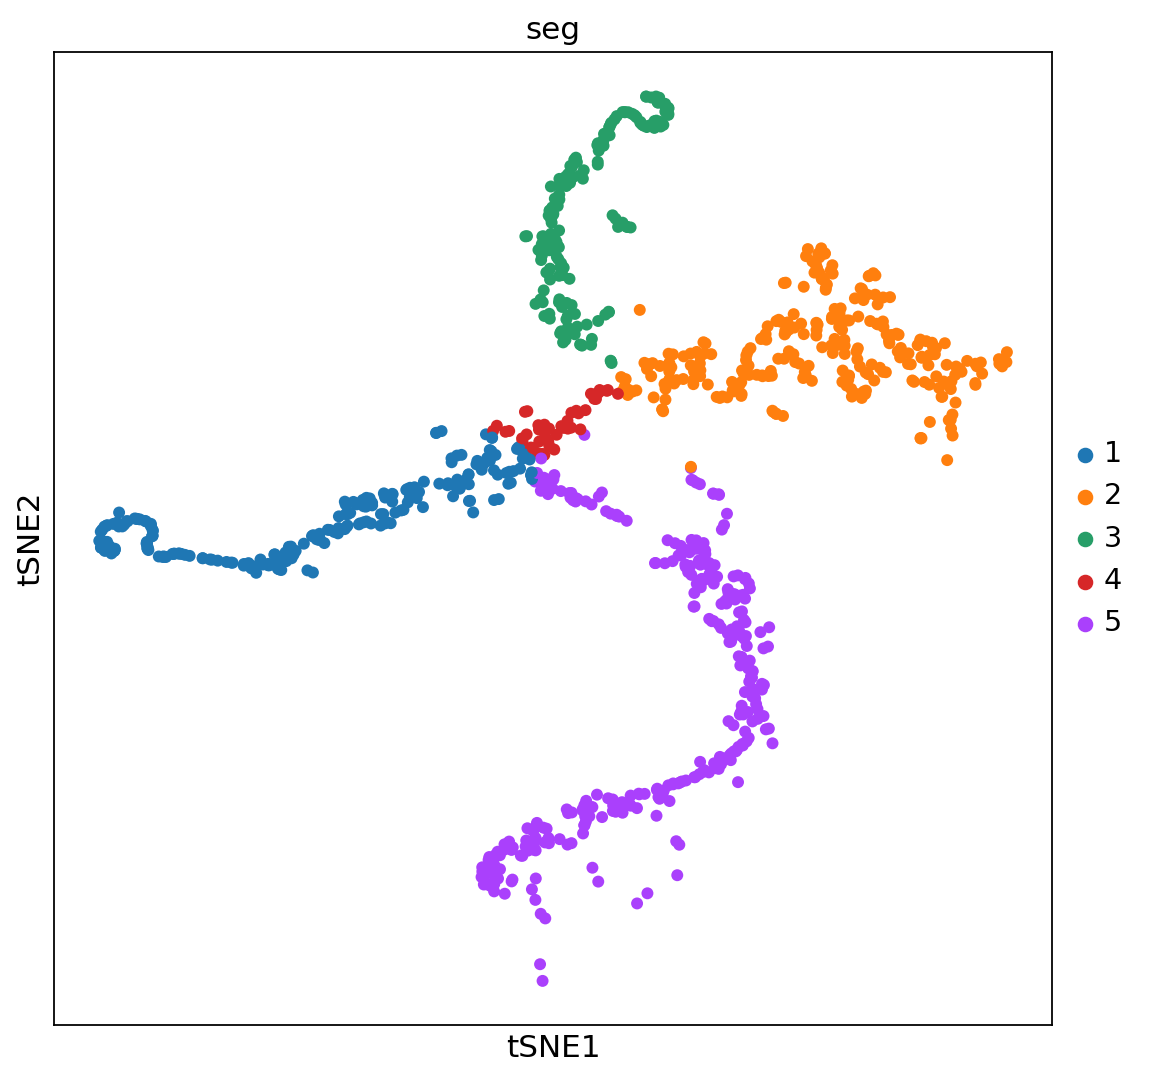

In [89]:
sc.pl.tsne(adata,color="seg")

In [92]:
import numpy as np
import pandas as pd
from functools import partial
from statsmodels.stats.weightstats import DescrStatsW
import matplotlib.pyplot as plt
def ampute(adata,devtime,win):
    adata=adata.copy()
    df=adata.uns["early_pool->II<>Ia"]["fork"]
    genesetA = df.index[(df["branch"]=="II").values & (df["module"]=="early").values]
    genesetB = df.index[(df["branch"]=="Ia").values & (df["module"]=="early").values]
    genesets = np.concatenate([genesetA,genesetB])
    mlsc=adata.uns["milestones_colors"]
    c_mil=np.array(mlsc)[list(map(lambda m: np.argwhere(adata.obs.milestones.cat.categories.isin([m]))[0][0],["II","Ia"]))].flatten()    
    
    adata=adata[adata.uns["tree"]["cells_fitted"]]
    
    seg=adata.uns["tree"]["pp_info"].iloc[adata.uns["tree"]["pp_info"].time.idxmin()].seg
    
    sel_nodes=adata.uns["tree"]["pp_info"].index[adata.uns["tree"]["pp_info"].seg==seg]

    adata.uns["tree"]["pp_info"]=adata.uns["tree"]["pp_info"].loc[adata.uns["tree"]["pp_info"].seg==seg,:]
    segs_cur = [seg]
    sel_cells=(adata.obs.seg==segs_cur[0]) & (adata.obs.devtime==devtime)

    adata.uns["tree"]["B"]=adata.uns["tree"]["B"][sel_nodes,:][:,sel_nodes]
    adata.uns["tree"]["F"]=adata.uns["tree"]["F"][:,sel_nodes]
    adata.uns["tree"]["R"]=adata.uns["tree"]["R"][sel_cells,:][:,sel_nodes]

    adata=adata[sel_cells,]
    adata.uns["tree"]["cells_fitted"]=adata.obs_names
    scf.tl.root(adata,np.argwhere(sel_nodes==adata.uns["tree"]["root"])[0][0])
    scf.tl.pseudotime(adata)
    
    tree=adata.uns["tree"]
    pps = tree["pp_info"].PP[tree["pp_info"].seg.isin(['1'])].index
    pp_probs = tree["R"].sum(axis=0)
    seg_progenies = ["1"]
    segs_cur = seg_progenies
    def region_extract(pt_cur,segs_cur):
        freq = list()

        pp_next = pps[(tree["pp_info"].loc[pps,"time"].values >= pt_cur) & 
                      tree["pp_info"].loc[pps,"seg"].isin(segs_cur).values]


        cmsm = np.cumsum(pp_probs[pp_next][np.argsort(tree["pp_info"].loc[pp_next,"time"].values)])
        inds=np.argwhere(cmsm > win).flatten()

        if len(inds)==0:
            if (cmsm.max() > win/2):
                if mapping:
                    cell_probs = tree["R"][:,pp_next].sum(axis=1)
                else:
                    cell_probs = np.isin(np.apply_along_axis(lambda x: np.argmax(x),axis=1,arr=tree["R"]),pp_next)*1
                freq = freq+[cell_probs]
            return freq
        else: 
            pps_region = pp_next[np.argsort(tree["pp_info"].loc[pp_next,"time"].values)][:inds[0]]
            if mapping:
                cell_probs = tree["R"][:,pps_region].sum(axis=1)
            else:
                cell_probs = np.isin(np.apply_along_axis(lambda x: np.argmax(x),axis=1,arr=tree["R"]),pps_region)*1

            freq = freq+[cell_probs]
            pt_cur = tree["pp_info"].loc[pps_region,"time"].max()


            if (sum(~tree["pp_info"].loc[pps_region,:].seg.isin(seg_progenies))==0):
                res = region_extract(pt_cur,segs_cur)
                return freq+res
    mapping: bool = True
        
    pt_cur = tree["pp_info"].loc[pps,"time"].min()
    freqs=region_extract(pt_cur,segs_cur)
        
    freqs=list(map(lambda f: pd.Series(f,index=adata.obs_names),freqs))
    print(genesetA)
    X = adata[:,genesets].layers["fpm"]
    X=pd.DataFrame(X,index=adata.obs_names,columns=genesets)
    X_r=X.rank(axis=0)
    def gather_cor(i,geneset):
        freq=freqs[i][adata.obs_names]
        cormat = pd.DataFrame(DescrStatsW(X_r.values,weights=freq).corrcoef,
                              index=genesets,columns=genesets)
        np.fill_diagonal(cormat.values, np.nan)
        return cormat.loc[:,geneset].mean(axis=1)

    gather = partial(gather_cor, geneset=genesetA)
    corA=pd.concat(list(map(gather,range(len(freqs)))),axis=1)

    gather = partial(gather_cor, geneset=genesetB)
    corB=pd.concat(list(map(gather,range(len(freqs)))),axis=1)

    corAB=pd.concat([corA,corB], keys=["II","Ia"]) 
    corAB.columns=[str(c) for c in corAB.columns]
    nwin=len(freqs)
    from matplotlib.colors import LinearSegmentedColormap
    fig, axs = plt.subplots(2,nwin,figsize=(nwin*3, 6))

    fig.subplots_adjust(hspace = .05, wspace=.05)
    emb=adata[adata.uns["tree"]["cells_fitted"],:].obsm["X_tsne"]


    corA=corAB.loc["II"].copy()
    corB=corAB.loc["Ia"].copy()
    groupsA=np.ones(corA.shape[0])
    groupsA[corA.index.isin(genesetB)]=2  
    groupsB=np.ones(corA.shape[0])
    groupsB[corA.index.isin(genesetA)]=2
    gr=LinearSegmentedColormap.from_list("greyreds",["lightgrey","black"])

    maxlim=np.max([corB.max().max(),np.abs(corB.min().min()),corA.max().max(),np.abs(corA.min().min())])+0.01
    
    for i in range(nwin):
        freq=freqs[i]
        axs[0,i].scatter(emb[np.argsort(freq),0],emb[np.argsort(freq),1],
                         s=10,c=freq[np.argsort(freq)],cmap=gr)
        axs[0,i].grid(b=None)
        axs[0,i].set_xticks([]) 
        axs[0,i].set_yticks([]) 

    
    genesets=[genesetA,genesetB]
    for i in range(nwin):
        for j in range(2):
            axs[1,i].scatter(corA.loc[genesets[j],str(i)],corB.loc[genesets[j],str(i)],
                             color=c_mil[j],alpha=.5)
        rep=(np.corrcoef(groupsA,corA.iloc[:,i])[0][1]+np.corrcoef(groupsB,corB.iloc[:,i])[0][1])/2
        axs[1,i].annotate(str(round(rep,2)), xy=(0.7,0.88),xycoords='axes fraction',fontsize=16)
        axs[1,i].grid(b=None)
        axs[1,i].axvline(0,linestyle="dashed",color="grey",zorder=0)
        axs[1,i].axhline(0,linestyle="dashed",color="grey",zorder=0)
        axs[1,i].set_xlim([-maxlim,maxlim])
        axs[1,i].set_ylim([-maxlim,maxlim])
        axs[1,i].set_xticks([]) 
        axs[1,i].set_yticks([]) 
    
    plt.savefig("figures/amputed_cor_"+devtime+".png")
    return corAB

In [95]:
df=adata.uns["early_pool->II<>Ia"]["fork"]
genesetA = df.index[(df["branch"]=="II").values & (df["module"]=="early").values]
genesetB = df.index[(df["branch"]=="Ia").values & (df["module"]=="early").values]

In [70]:
adata.uns["tree"]["root"]

173

Trying to set attribute `.uns` of view, copying.


root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:00) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)
Index(['Zdhhc12', 'Rprm', 'Shf', 'Dok5', 'Necab1', 'Slc24a2', 'Gabra2',
       'Slc10a4', 'Cyth3', 'Snca', 'Gmip', 'Zfhx3', 'Kirrel3', 'Eya4', 'Id2',
       'F2r', '2410124H12Rik', 'Tle4'],
      dtype='object')


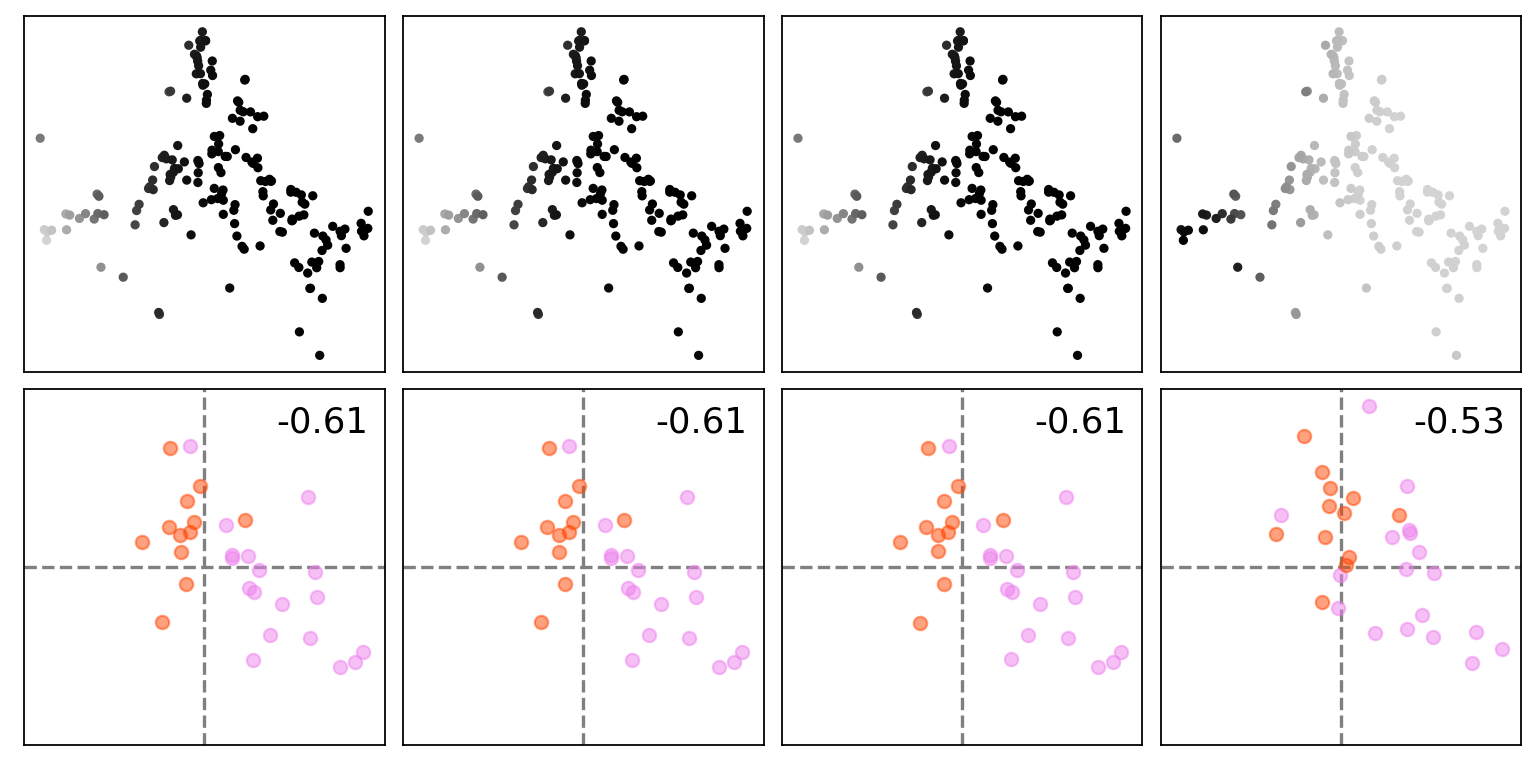

In [93]:
corAB_E16=ampute(adata,"E16.5",50)

Trying to set attribute `.uns` of view, copying.


root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)
projecting cells onto the principal tree
    finished (0:00:00) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)
Index(['Zdhhc12', 'Rprm', 'Shf', 'Dok5', 'Necab1', 'Slc24a2', 'Gabra2',
       'Slc10a4', 'Cyth3', 'Snca', 'Gmip', 'Zfhx3', 'Kirrel3', 'Eya4', 'Id2',
       'F2r', '2410124H12Rik', 'Tle4'],
      dtype='object')


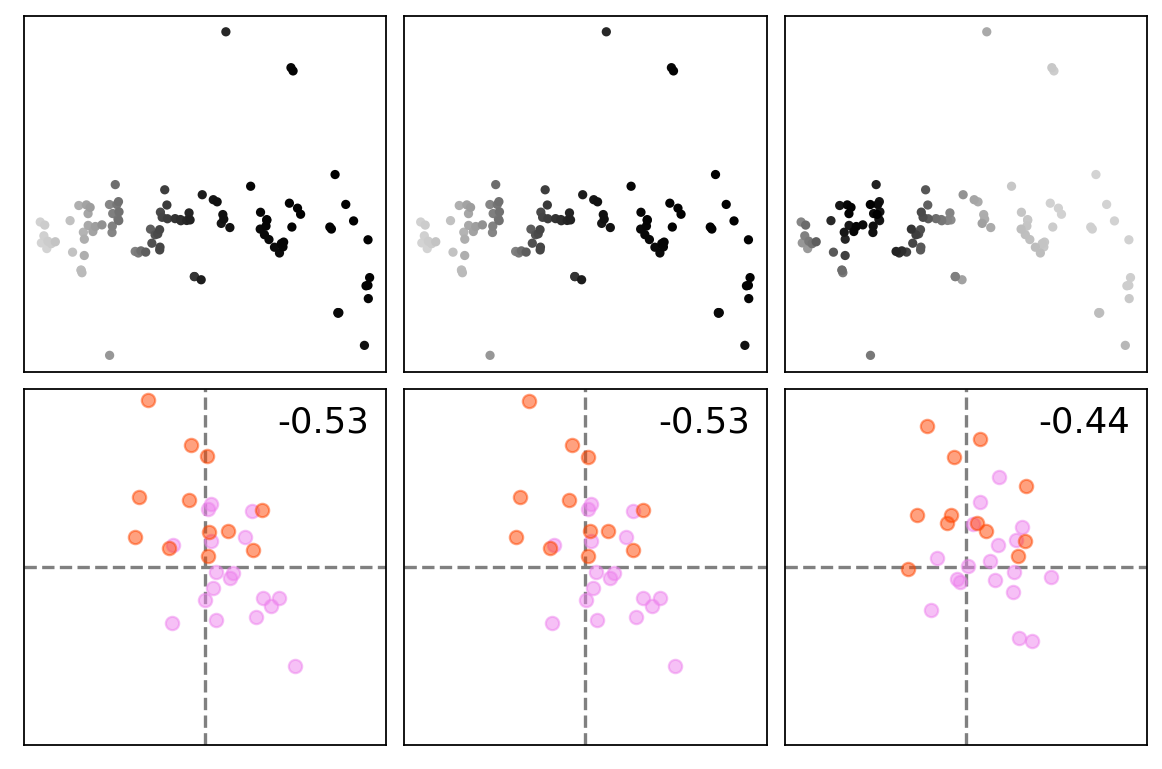

In [99]:
corAB_E18=ampute(adata,"E18.5",30)

In [157]:
corner_II=list(set(corAB_E16.loc["II","0"].index[corAB_E16.loc["II","0"]>0].tolist()).intersection(corAB_E16.loc["Ia","0"].index[corAB_E16.loc["Ia","0"]<0].tolist()))
genesetA = df.index[(df["branch"]=="II").values & (df["module"]=="early").values]
genesetA_s=list(set(genesetA.tolist()).intersection(corner_II))
(corAB_E16.loc[:,"0"].loc["II"].loc[genesetA_s]**2+(-corAB_E16.loc[:,"0"].loc["Ia"].loc[genesetA_s])**2).sort_values(ascending=False)[:4].index

Index(['F2r', 'Necab1', 'Tle4', 'Gabra2'], dtype='object')

In [158]:
corner_Ia=list(set(corAB_E16.loc["Ia","0"].index[corAB_E16.loc["Ia","0"]>0].tolist()).intersection(corAB_E16.loc["II","0"].index[corAB_E16.loc["II","0"]<0].tolist()))
genesetB = df.index[(df["branch"]=="Ia").values & (df["module"]=="early").values]
genesetB_s=list(set(genesetB.tolist()).intersection(corner_Ia))
(corAB_E16.loc[:,"0"].loc["Ia"].loc[genesetB_s]**2+(-corAB_E16.loc[:,"0"].loc["II"].loc[genesetB_s])**2).sort_values(ascending=False)[:4].index

Index(['Kcnh5', 'Tmem266', 'Nudt17', 'Brinp3'], dtype='object')

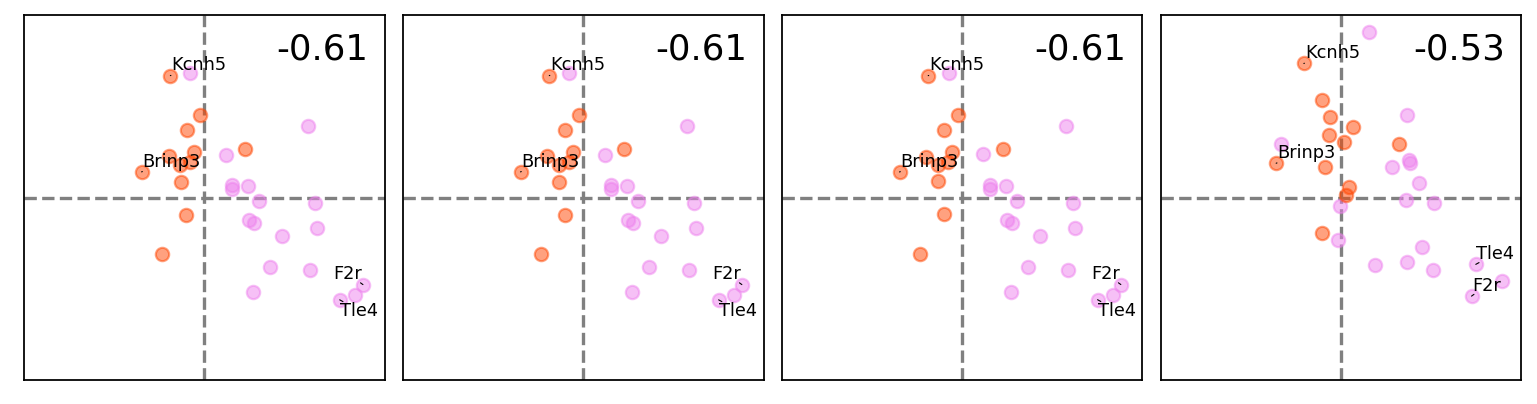

In [173]:
geneset=['Kcnh5', 'Brinp3','F2r', 'Tle4']


mlsc=adata.uns["milestones_colors"]
c_mil=np.array(mlsc)[list(map(lambda m: np.argwhere(adata.obs.milestones.cat.categories.isin([m]))[0][0],["II","Ia"]))].flatten()   
corAB=corAB_E16
nwin=corAB.shape[1]
fig, axs = plt.subplots(1,nwin,figsize=(nwin*3, 3))
from matplotlib.colors import LinearSegmentedColormap
fig.subplots_adjust(hspace = .05, wspace=.05)
emb=adata[adata.uns["tree"]["cells_fitted"],:].obsm["X_tsne"]


corA=corAB.loc["II"].copy()
corB=corAB.loc["Ia"].copy()
groupsA=np.ones(corA.shape[0])
groupsA[corA.index.isin(genesetB)]=2  
groupsB=np.ones(corA.shape[0])
groupsB[corA.index.isin(genesetA)]=2
gr=LinearSegmentedColormap.from_list("greyreds",["lightgrey","black"])

maxlim=np.max([corB.max().max(),np.abs(corB.min().min()),corA.max().max(),np.abs(corA.min().min())])+0.01 

from adjustText import adjust_text

genesets=[genesetA,genesetB]
for i in range(nwin):
    for j in range(2):
        axs[i].scatter(corA.loc[genesets[j],str(i)],corB.loc[genesets[j],str(i)],
                         color=c_mil[j],alpha=.5)
    rep=(np.corrcoef(groupsA,corA.iloc[:,i])[0][1]+np.corrcoef(groupsB,corB.iloc[:,i])[0][1])/2
    axs[i].annotate(str(round(rep,2)), xy=(0.7,0.88),xycoords='axes fraction',fontsize=16)
    axs[i].grid(b=None)
    axs[i].axvline(0,linestyle="dashed",color="grey",zorder=0)
    axs[i].axhline(0,linestyle="dashed",color="grey",zorder=0)
    axs[i].set_xlim([-maxlim,maxlim])
    axs[i].set_ylim([-maxlim,maxlim])
    axs[i].set_xticks([]) 
    axs[i].set_yticks([])
    xs=corA.loc[geneset,str(i)]
    ys=corB.loc[geneset,str(i)]
    
    texts=[]
    for x, y, l in zip(xs, ys, geneset):
        texts.append(axs[i].text(x, y, l, size=8))
    adjust_text(texts,ha='left', va='center',arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=axs[i])
    
plt.savefig("figures/amputed_cor_E16_2.png")

In [165]:
corner_II=list(set(corAB_E18.loc["II","0"].index[corAB_E18.loc["II","0"]>0].tolist()).intersection(corAB_E18.loc["Ia","0"].index[corAB_E18.loc["Ia","0"]<0].tolist()))
genesetA = df.index[(df["branch"]=="II").values & (df["module"]=="early").values]
genesetA_s=list(set(genesetA.tolist()).intersection(corner_II))
(corAB_E18.loc[:,"0"].loc["II"].loc[genesetA_s]**2+(-corAB_E18.loc[:,"0"].loc["Ia"].loc[genesetA_s])**2).sort_values(ascending=False)[:4].index

Index(['F2r', 'Snca', 'Id2', 'Tle4'], dtype='object')

In [166]:
corner_Ia=list(set(corAB_E18.loc["Ia","0"].index[corAB_E18.loc["Ia","0"]>0].tolist()).intersection(corAB_E18.loc["II","0"].index[corAB_E18.loc["II","0"]<0].tolist()))
genesetB = df.index[(df["branch"]=="Ia").values & (df["module"]=="early").values]
genesetB_s=list(set(genesetB.tolist()).intersection(corner_Ia))
(corAB_E18.loc[:,"0"].loc["Ia"].loc[genesetB_s]**2+(-corAB_E18.loc[:,"0"].loc["II"].loc[genesetB_s])**2).sort_values(ascending=False)[:4].index

Index(['Vsnl1', 'Kcnn2', 'Grem2', 'Brinp3'], dtype='object')

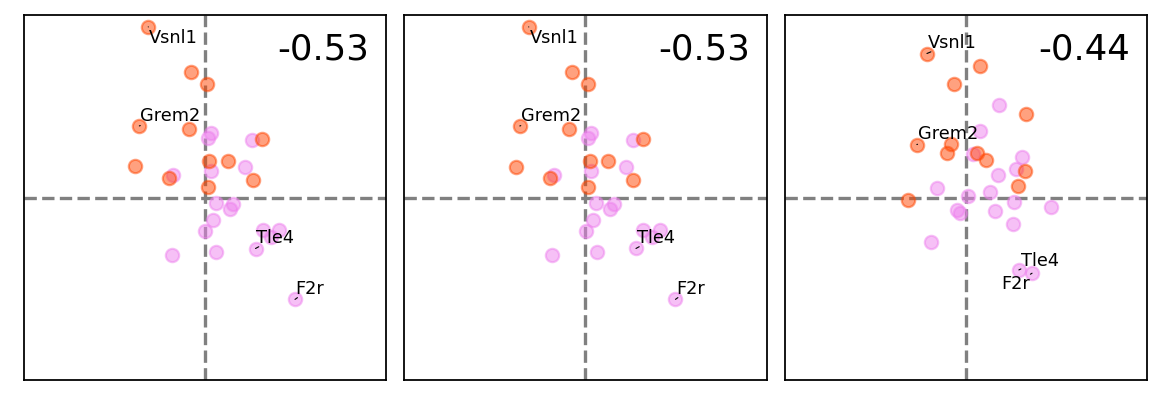

In [174]:
geneset=['Vsnl1','Grem2', 'F2r', 'Tle4']


mlsc=adata.uns["milestones_colors"]
c_mil=np.array(mlsc)[list(map(lambda m: np.argwhere(adata.obs.milestones.cat.categories.isin([m]))[0][0],["II","Ia"]))].flatten()   
corAB=corAB_E18
nwin=corAB.shape[1]
fig, axs = plt.subplots(1,nwin,figsize=(nwin*3, 3))
from matplotlib.colors import LinearSegmentedColormap
fig.subplots_adjust(hspace = .05, wspace=.05)
emb=adata[adata.uns["tree"]["cells_fitted"],:].obsm["X_tsne"]


corA=corAB.loc["II"].copy()
corB=corAB.loc["Ia"].copy()
groupsA=np.ones(corA.shape[0])
groupsA[corA.index.isin(genesetB)]=2  
groupsB=np.ones(corA.shape[0])
groupsB[corA.index.isin(genesetA)]=2
gr=LinearSegmentedColormap.from_list("greyreds",["lightgrey","black"])

maxlim=np.max([corB.max().max(),np.abs(corB.min().min()),corA.max().max(),np.abs(corA.min().min())])+0.01 

from adjustText import adjust_text

genesets=[genesetA,genesetB]
for i in range(nwin):
    for j in range(2):
        axs[i].scatter(corA.loc[genesets[j],str(i)],corB.loc[genesets[j],str(i)],
                         color=c_mil[j],alpha=.5)
    rep=(np.corrcoef(groupsA,corA.iloc[:,i])[0][1]+np.corrcoef(groupsB,corB.iloc[:,i])[0][1])/2
    axs[i].annotate(str(round(rep,2)), xy=(0.7,0.88),xycoords='axes fraction',fontsize=16)
    axs[i].grid(b=None)
    axs[i].axvline(0,linestyle="dashed",color="grey",zorder=0)
    axs[i].axhline(0,linestyle="dashed",color="grey",zorder=0)
    axs[i].set_xlim([-maxlim,maxlim])
    axs[i].set_ylim([-maxlim,maxlim])
    axs[i].set_xticks([]) 
    axs[i].set_yticks([])
    xs=corA.loc[geneset,str(i)]
    ys=corB.loc[geneset,str(i)]
    
    texts=[]
    for x, y, l in zip(xs, ys, geneset):
        texts.append(axs[i].text(x, y, l, size=8))
    adjust_text(texts,ha='left', va='center',arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=axs[i])
    
plt.savefig("figures/amputed_cor_E18_2.png")

In [121]:
corA.loc[['F2r', 'Snca', 'Id2', 'Tle4'],str(i)]

F2r     0.078610
Snca    0.039507
Id2     0.039937
Tle4    0.081178
Name: 3, dtype: float64